In [214]:
import pandas as pd
import numpy as np
from pathlib import Path
import wave
import sys
import soundfile as sf
# from pydub import AudioSegment
from scipy.io import wavfile
from dataclasses import (
    dataclass,
    asdict,
    fields,
)
from typing import (
    Optional,
    Callable,
    Set,
    Generator,
    List,
    Tuple,
    Union,
    Dict,
    Iterable,
)
from functools import (
    partial,
)
import time
import dill
import logging
import multiprocessing
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
import transformers
import torch
import pickle
import seaborn as sns
from enum import Enum
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import (
    StandardScaler, 
    LabelEncoder,
)
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance, partial_dependence
from sklearn.utils._bunch import Bunch

import matplotlib.pyplot as plt

sys.path.append(os.getenv('MASTER_DEPLOMA_PROJECT_FILE_PATH'))
from audio import (
    Audio,
    WAVFilePathInitArgs,
)
from text.profanity import (
    PROFANITY_WORD_FILTER_LANG_NAME,
)
from configs.base import (
    RB_OPEN_FILE_MODE,
    SECONDS_QUANTITY_IN_MINUTE,
    TAB,
    RUSSIAN_VOWELS,
    WB_OPEN_FILE_MODE,
    DROP_DUPLICATES_KEEP_FIRST,
    JOIN_HOW_INNER,
    AGGREGATED_KEYWORD,
)
from configs.paths import (
    DUSHA_CROWD_TRAIN_FILE_PATH,
    DUSHA_CROWD_TEST_FILE_PATH,
    DUSHA_CROWD_TRAIN_WAVS_DIR_PATH,
    DUSHA_CROWD_TEST_WAVS_DIR_PATH,
    PROCESSED_DUSHA_CROWD_TRAIN_HLF_LAST_VERSION_FILE_PATH,
    PROCESSED_DUSHA_CROWD_TEST_HLF_LAST_VERSION_FILE_PATH,
    PROCESSED_DUSHA_CROWD_TRAIN_HLF_STABLE_VERSION_FILE_PATH,
    PROCESSED_DUSHA_CROWD_TEST_HLF_STABLE_VERSION_FILE_PATH,
    DO_NOT_EXTRACTED_FEATUERS_HASHES_FILE_PATH,
    PROCESSED_DUSHA_SER_TABLES_TRAIN_FILE_PATH,
    PROCESSED_DUSHA_SER_TABLES_TEST_FILE_PATH,
)
from configs.report_tables_format import (
    classification_report_formatted,
)
from configs.plots import (
    ALIGN_CENTER_KEYWORD,
    FEATURE_RU,
    NORMED_WEIGHT_RU,
    XTICKS_DEFAULT_ROTATION,
    PARTIAL_DEPENDENCE_KIND_AVERAGE,
    PARTIAL_DEPENDENCE_GRID_VALUES,
)
from processing.text.normalization import (
    normalized_tokens_2_normalized_text,
    text_2_normalized_text,
)
from high_level_feature_extractor.text.profanity import (
    text_2_is_contain_swear_words,
)
from high_level_feature_extractor.text.all import (
    TranscriptionHighLevelFeatures,
)
from high_level_feature_extractor.text.POS import (
    POS_ratio,
)
from high_level_feature_extractor.extractor import (
    HighLevelSpeechFeatures,
    HashHLF,
    hash_HLF_list_2_df,
    PronounceSpeed,
    asdict,
)
from high_level_feature_extractor.extract import (
    raw_crowd_2_HLF,
)
from high_level_feature_extractor.extractor import (
    HLF_ENG_NAME_2_RU_NAME,
)
from utils.dataclass import (
    flatten_dict,
)
from volume.human_speech import (
    HIGH_FREQUENCY_SPEECH_THRESHOLD,
)
from configs.paths import (
    PROCESSED_DUSHA_CROWD_TRAIN_DIR_PATH,
    PROCESSED_DUSHA_CROWD_TEST_DIR_PATH,
    PROCESSED_DUSHA_CROWD_TRAIN_TEXT_EMBEDDINGS_LAST_VERSION_FILE_PATH,
    PROCESSED_DUSHA_CROWD_TEST_TEXT_EMBEDDINGS_LAST_VERSION_FILE_PATH,
)
from models.config import (
    TORCH_TENSORS_KEYWOED,
    ATTENTION_MASK_KEYWORD,
    SKLEARN_MULTINOMIAL_KEYWORD,
)
from models.text_embedding.ru_en_RoSBERTa import (
    DEVICE as ROSBERTA_DEVICE,
    NORMALIZE_P as ROSBERTA_NORMALIZE_P,
    NORMALIZE_DIM as ROSBERTA_NORMALIZE_DIM,
    CLAMP_MIN,
)
from config import (
    SPEAKER_TEXT_FIELD_NAME,
    PREDICTIONS_COL_NAME,
    RANDOM_SEED,
)
from utils.parallel_processing import (
    divide_into_chunks,
)
from configs.datasets.dusha import (
    HASH_ID_COLUMN_NAME,
    GoldenEmo,
    SPEAKER_EMOTION_FIELD_NAME,
    ANNOTATOR_EMOION_FIELD_NAME,
    ANNOTATOR_ANSWERS_AGGREGATING_THRESHOLD,
    ANNOTATOR_AGGREGATED_FIELD_NAME,
    aggregate_crowd,
)
from processing.text.normalization import (
    text_to_normalized_tokens,
)
from configs.datasets.aggregation import (
    aggregate_by_mode,
)
from models.quality_estimating.feature_importance import (
    normalized_feature_importance,
)
from metrics.classification.confusion_matrix import(
    show_all_classification_metrics,
)
from metrics.insights.feature_importance import (
    normalized_feature_importance_plot,
)

In [16]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%load_ext autoreload
%autoreload all

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Extract

## HLF

In [18]:
EXAMPLE_AUDIO_PATH:Path = Path('/data01/vvkiselev/data/other/dpl/dusha/crowd/crowd_train/wavs/000039c2bc753aa5a776621a4707eb73.wav')

In [19]:
# audio_example:Audio = Audio.wav_file_path_init(path=EXAMPLE_AUDIO_PATH, transcription='ахах, пиздец')
arguments:WAVFilePathInitArgs = WAVFilePathInitArgs(path=EXAMPLE_AUDIO_PATH, transcription='ахах, пиздец')
audio_example:Audio = Audio.wav_file_path_init(arguments=arguments)
audio_example

Audio(hash='000039c2bc753aa5a776621a4707eb73', sample_width=2, sr=16000, n_frames=165120, data=array([ 0,  0,  0, ..., -2,  6, -9], dtype=int16), n_channels=1, _transcription='ахах, пиздец')

In [20]:
# HLF_example:HighLevelSpeechFeatures = HighLevelSpeechFeatures.wav_path_init(path=EXAMPLE_AUDIO_PATH, transcription='бля зачем')
HLF_example:HighLevelSpeechFeatures = HighLevelSpeechFeatures.audio_init(audio=audio_example)
HLF_example

HighLevelSpeechFeatures(loudness=59.77829826935232, HF_power_ratio=0.054469042401762625, pronounce_speed=PronounceSpeed(WPS=1.065891472868217, LPS=0.9689922480620154, SPS=0.38759689922480617), transcription_features=TranscriptionHighLevelFeatures(mean_words_length=5.0, profanity_words_ratio=0.5, meaning=4.454233000760066e-05, POS_ratio=POS_ratio(ADVB=0.0, COMP=0.0, CONJ=0.0, GRND=0.0, INFN=0.0, INTJ=0.0, PRCL=0.0, PRED=0.0, PREP=0.0, VERB=0.0, ADJS=0.0, PRTS=0.0, NPRO=0.0, NOUN=1.0, ADJF=0.0, NUMR=0.0, PRTF=0.0, NONE=0.0)))

In [23]:
raw_crowd_train, raw_crowd_test = list(map(lambda path: pd.read_csv(path, sep=TAB), [DUSHA_CROWD_TRAIN_FILE_PATH, DUSHA_CROWD_TEST_FILE_PATH]))
print(raw_crowd_train.shape)
display(raw_crowd_train.head(2))

print(raw_crowd_test.shape)
display(raw_crowd_test.head(2))

(906953, 9)


,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
0,475e76f77ac1ed7cabafca740b15b32a,wavs/475e76f77ac1ed7cabafca740b15b32a.wav,2.453,angry,NaN,858305a5450b7bd1288ba0053b1cd1c1,не надо не надо не надо не надо,angry,fa136da095807ea6cd18dd6e2f58d4d0
1,2f9438ef68395c70a8714dc373a49d11,wavs/2f9438ef68395c70a8714dc373a49d11.wav,4.640,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,фозил кори mp три,neutral,3d436884cbbe25373914f8768de494f7


(79088, 9)


,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
0,9e9961c53ca6eeb440b217e539fbf46c,wavs/9e9961c53ca6eeb440b217e539fbf46c.wav,5.82,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,я слушаю,neutral,4282ddc30d71ef420e202e0c60391e9f
1,0166f65a30354db8282682b1a280e64c,wavs/0166f65a30354db8282682b1a280e64c.wav,3.70,sad,NaN,858305a5450b7bd1288ba0053b1cd1c1,каким стал сбер,neutral,d70dc98ed56e9362eaefefb7b2827c8f


In [24]:
raw_crowd_train[raw_crowd_train.hash_id == '5d9560dd2cba88b2dc87b6b4d5b6a29d']

,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
412403,5d9560dd2cba88b2dc87b6b4d5b6a29d,wavs/5d9560dd2cba88b2dc87b6b4d5b6a29d.wav,0.347875,other,NaN,09184134bd1ddeb646205ba8e981fba8,фильмы меньшова,sad,24725b876b5e72993ec6c35688f754b8
412437,5d9560dd2cba88b2dc87b6b4d5b6a29d,wavs/5d9560dd2cba88b2dc87b6b4d5b6a29d.wav,0.347875,other,NaN,076ffc89109d8d0cb8727de8f75b5c94,фильмы меньшова,sad,24725b876b5e72993ec6c35688f754b8
412457,5d9560dd2cba88b2dc87b6b4d5b6a29d,wavs/5d9560dd2cba88b2dc87b6b4d5b6a29d.wav,0.347875,other,NaN,62942acb4975e3cac00d06726a0dfd83,фильмы меньшова,sad,24725b876b5e72993ec6c35688f754b8
414061,5d9560dd2cba88b2dc87b6b4d5b6a29d,wavs/5d9560dd2cba88b2dc87b6b4d5b6a29d.wav,0.347875,other,NaN,a30fefe82e1e460f186efe6e9bbf9c58,фильмы меньшова,sad,24725b876b5e72993ec6c35688f754b8


In [26]:
len(raw_crowd_train.hash_id.unique()), len(raw_crowd_test.hash_id.unique())

(184633, 17217)

### Analyse

In [27]:
def read_HLF_file(
    HLF_file_path:Path = PROCESSED_DUSHA_CROWD_TRAIN_HLF_STABLE_VERSION_FILE_PATH,
    )->List[HashHLF]:
    hash_HLF_list:List[HashHLF] = []
    with open(HLF_file_path) as f:
        for line in f:
            el:Optional[HashHLF] = eval(eval(line)) if eval(line) is not None else None
            if el is not None:
                hash_HLF_list.append(el)
                
    return hash_HLF_list

In [28]:
def raw_crowd_2_raw_crowd_HLF_table_format(
    raw_crowd:pd.DataFrame,
    agg_col_name:str = ANNOTATOR_AGGREGATED_FIELD_NAME,
    ):
    raw_crowd_test_agged:pd.DataFrame = aggregate_crowd(
        df=raw_crowd, 
        aggregated_col_name=agg_col_name,
    )

    raw_crowd_unique_hashes:pd.DataFrame = raw_crowd_test_agged[~raw_crowd_test_agged.index.duplicated()]
    # raw_crowd_train_unique_hashes_only_goldens:pd.DataFrame = raw_crowd_train_unique_hashes[~raw_crowd_train_unique_hashes.golden_emo.isna()]
    # raw_crowd_unique_hashes_with_speaker_emo:pd.DataFrame = raw_crowd_unique_hashes[~raw_crowd_unique_hashes.speaker_emo.isna()]
    # raw_crowd_unique_hashes_with_speaker_emo_with_speaker_text:pd.DataFrame = raw_crowd_unique_hashes_with_speaker_emo[~raw_crowd_unique_hashes_with_speaker_emo[agg_col_name].isna()]
    # raw_crowd_unique_hashes_with_speaker_emo_with_speaker_text.set_index(HASH_ID_COLUMN_NAME, drop=True, inplace=True)
    # raw_crowd_train_unique_hashes_only_goldens_with_speaker_text.golden_emo = raw_crowd_train_unique_hashes_only_goldens_with_speaker_text.golden_emo.apply(lambda x: GoldenEmo(round(x)).name)
    # raw_crowd_train_unique_hashes_only_goldens.index.name=None
    return raw_crowd_unique_hashes

In [30]:
raw_crowd:pd.DataFrame = raw_crowd_test
hash_id_2_annotator_emo:pd.Series = pd.Series(
    index=raw_crowd.hash_id.to_list(), 
    data=raw_crowd.annotator_emo.to_list(),
).sort_index()
grouped = hash_id_2_annotator_emo.groupby(hash_id_2_annotator_emo.index).apply(aggregate_by_mode).dropna()
grouped.name = ANNOTATOR_AGGREGATED_FIELD_NAME
grouped.head()

0004eb46b532c20b2f181f1a65d3ff17    neutral
0006985a7b739719a77be07ff64a4274    neutral
00117e5b11d1490c25eea137983ca994    neutral
00173c4925e5a20cd1495742505ec0d2        sad
001b5ccc41a9c3a98f07c91420849a11      angry
Name: annotator_emo_aggregated, dtype: object

In [31]:
raw_crowd_train.head()

,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
0,475e76f77ac1ed7cabafca740b15b32a,wavs/475e76f77ac1ed7cabafca740b15b32a.wav,2.453000,angry,NaN,858305a5450b7bd1288ba0053b1cd1c1,не надо не надо не надо не надо,angry,fa136da095807ea6cd18dd6e2f58d4d0
1,2f9438ef68395c70a8714dc373a49d11,wavs/2f9438ef68395c70a8714dc373a49d11.wav,4.640000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,фозил кори mp три,neutral,3d436884cbbe25373914f8768de494f7
2,9937036a9c0dba20eecbffddd00f2be2,wavs/9937036a9c0dba20eecbffddd00f2be2.wav,4.341750,neutral,2.0,858305a5450b7bd1288ba0053b1cd1c1,NaN,NaN,NaN
3,fb0ae78586a235018103acec22a80a8f,wavs/fb0ae78586a235018103acec22a80a8f.wav,3.900562,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,сколько стоит на керамбит,neutral,80bc833cf6b3f106d2e8991783a31e2b
4,196dcf9e1aaac46c2aee45e7f6adfb92,wavs/196dcf9e1aaac46c2aee45e7f6adfb92.wav,4.780000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,афина когда закончится эта телепередача,neutral,bd78f079676fa5f1ed17253c9a440cc6


In [32]:
def HLF_withspeaker_emottions_table(
    raw_crowd:pd.DataFrame,
    HLF_file_path:Path,
    agg_col_name:str = ANNOTATOR_AGGREGATED_FIELD_NAME,
    filter_agg_emo_equal_2_speaker_emo:bool=False,
    )->pd.DataFrame:
    hash_HLF_list:List[HashHLF] = read_HLF_file(HLF_file_path=HLF_file_path)
    HLF_table:pd.DataFrame = hash_HLF_list_2_df(l=hash_HLF_list)

    # raw_crowd_unique_hashes_with_speaker_emo_with_speaker_text:pd.DataFrame = raw_crowd_2_raw_crowd_HLF_table_format(raw_crowd=raw_crowd, agg_col_name=agg_col_name)
    hash_id_list:List[str] = raw_crowd.hash_id.to_list()
    hash_id_2_annotator_emo:pd.Series = pd.Series(
        index=hash_id_list, 
        data=raw_crowd.annotator_emo.to_list(),
    ).sort_index()
    hash_2_aggregated_target:pd.Series = hash_id_2_annotator_emo.groupby(hash_id_2_annotator_emo.index).apply(aggregate_by_mode).dropna()
    hash_2_aggregated_target.name = agg_col_name

    if filter_agg_emo_equal_2_speaker_emo:
        print(f'Before comparing with speaker_emo hash_2_aggregated_target.shape[0]= {hash_2_aggregated_target.shape[0]}')
        hash_id_2_speaker_emo:pd.Series = pd.Series(
            index = hash_id_list,
            data = raw_crowd.speaker_emo.to_list(),
            name=raw_crowd.speaker_emo.name,
        )
        hash_id_2_speaker_emo = hash_id_2_speaker_emo[~hash_id_2_speaker_emo.index.duplicated(keep='first')]
        hash_2_aggregated_target_with_speaker_emo:pd.DataFrame = pd.concat([hash_2_aggregated_target, hash_id_2_speaker_emo], axis=1)
        hash_2_aggregated_target = hash_2_aggregated_target_with_speaker_emo[hash_2_aggregated_target_with_speaker_emo.speaker_emo == hash_2_aggregated_target_with_speaker_emo[agg_col_name]][agg_col_name]
        print(f'Before comparing with speaker_emo hash_2_aggregated_target.shape[0]= {hash_2_aggregated_target.shape[0]}')


    HLF_with_speaker_emotions:pd.DataFrame = HLF_tablabel_encoderjoin(
        hash_2_aggregated_target, 
        how=JOIN_HOW_INNER,
    )
    return HLF_with_speaker_emotions

In [38]:
# Process
# HLF_with_speaker_emotions_train:pd.DataFrame = HLF_withspeaker_emottions_table(
#     raw_crowd=raw_crowd_train,
#     HLF_file_path=PROCESSED_DUSHA_CROWD_TRAIN_HLF_STABLE_VERSION_FILE_PATH
# )

# Read
HLF_with_speaker_emotions_train:pd.DataFrame = pd.read_csv(PROCESSED_DUSHA_SER_TABLES_TRAIN_FILE_PATH, index_col=0)
print(HLF_with_speaker_emotions_train.shape)
display(HLF_with_speaker_emotions_train.head())

(140293, 27)


,loudness,HF_power_ratio,pronounce_speed_WPS,pronounce_speed_LPS,pronounce_speed_SPS,transcription_features_mean_words_length,transcription_features_profanity_words_ratio,transcription_features_meaning,transcription_features_POS_ratio_ADVB,transcription_features_POS_ratio_COMP,transcription_features_POS_ratio_CONJ,transcription_features_POS_ratio_GRND,transcription_features_POS_ratio_INFN,transcription_features_POS_ratio_INTJ,transcription_features_POS_ratio_PRCL,transcription_features_POS_ratio_PRED,transcription_features_POS_ratio_PREP,transcription_features_POS_ratio_VERB,transcription_features_POS_ratio_ADJS,transcription_features_POS_ratio_PRTS,transcription_features_POS_ratio_NPRO,transcription_features_POS_ratio_NOUN,transcription_features_POS_ratio_ADJF,transcription_features_POS_ratio_NUMR,transcription_features_POS_ratio_PRTF,transcription_features_POS_ratio_NONE,annotator_emo_aggregated
475e76f77ac1ed7cabafca740b15b32a,72.867474,0.034653,9.783938,9.783938,4.891969,3.000000,0.0,0.000044,0.000000,0.0,0.000000,0.0,0.0,0.0,0.5,0.5,0.00,0.000000,0.00,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,angry
2f9438ef68395c70a8714dc373a49d11,59.619346,0.002489,3.017241,3.017241,1.077586,3.500000,0.0,0.000062,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.500000,0.0,0.25,0.0,0.25,neutral
fb0ae78586a235018103acec22a80a8f,65.745419,0.009645,5.640303,5.640303,2.051019,5.500000,0.0,0.000059,0.250000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.25,0.250000,0.25,0.0,0.0,0.000000,0.0,0.00,0.0,0.00,neutral
196dcf9e1aaac46c2aee45e7f6adfb92,43.632196,0.002487,7.322176,7.322176,3.556485,7.000000,0.0,0.000069,0.000000,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.00,0.200000,0.00,0.0,0.0,0.400000,0.2,0.00,0.0,0.00,neutral
41d7f48ca93b01e4a01a4f34b40a69ff,53.216042,0.037675,8.438819,8.438819,4.008439,5.714286,0.0,0.000079,0.142857,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.00,0.142857,0.00,0.0,0.0,0.571429,0.0,0.00,0.0,0.00,neutral


In [82]:
# HLF_with_speaker_emotions_train.to_csv(PROCESSED_DUSHA_SER_TABLES_TRAIN_FILE_PATH)

In [37]:
# process
# HLF_with_speaker_emotions_test:pd.DataFrame = HLF_withspeaker_emottions_table(
#     raw_crowd=raw_crowd_test,
#     HLF_file_path=PROCESSED_DUSHA_CROWD_TEST_HLF_LAST_VERSION_FILE_PATH
# )
HLF_with_speaker_emotions_test:pd.DataFrame = pd.read_csv(PROCESSED_DUSHA_SER_TABLES_TEST_FILE_PATH, index_col=0)
print(HLF_with_speaker_emotions_test.shape)
HLF_with_speaker_emotions_test.head()

(13208, 27)


,loudness,HF_power_ratio,pronounce_speed_WPS,pronounce_speed_LPS,pronounce_speed_SPS,transcription_features_mean_words_length,transcription_features_profanity_words_ratio,transcription_features_meaning,transcription_features_POS_ratio_ADVB,transcription_features_POS_ratio_COMP,transcription_features_POS_ratio_CONJ,transcription_features_POS_ratio_GRND,transcription_features_POS_ratio_INFN,transcription_features_POS_ratio_INTJ,transcription_features_POS_ratio_PRCL,transcription_features_POS_ratio_PRED,transcription_features_POS_ratio_PREP,transcription_features_POS_ratio_VERB,transcription_features_POS_ratio_ADJS,transcription_features_POS_ratio_PRTS,transcription_features_POS_ratio_NPRO,transcription_features_POS_ratio_NOUN,transcription_features_POS_ratio_ADJF,transcription_features_POS_ratio_NUMR,transcription_features_POS_ratio_PRTF,transcription_features_POS_ratio_NONE,annotator_emo_aggregated
9e9961c53ca6eeb440b217e539fbf46c,42.082995,0.016200,1.202749,1.202749,0.687285,3.500000,0.0,0.000043,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,neutral
0166f65a30354db8282682b1a280e64c,33.148046,0.002783,3.513514,3.513514,1.081081,4.333333,0.0,0.000054,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.333333,0.333333,0.0,0.0,0.0,sad
d49a6b560155831725a7bdc7d0a96099,51.286776,0.009615,4.794521,4.794521,1.598174,5.250000,0.0,0.000062,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.500000,0.000000,0.0,0.0,0.0,neutral
c6852b0925797612d7b6724da8cbe7b4,63.554106,0.006752,3.379953,3.379953,0.699301,5.800000,0.0,0.000059,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.200000,0.0,0.0,0.0,0.200000,0.000000,0.0,0.0,0.4,neutral
33152583dcbf1fe40d142954a2a7ca23,65.995071,0.005847,5.657895,5.657895,2.500000,4.300000,0.0,0.000092,0.00,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.200000,0.0,0.0,0.0,0.200000,0.100000,0.0,0.0,0.0,neutral


In [84]:
# HLF_with_speaker_emotions_test.to_csv(PROCESSED_DUSHA_SER_TABLES_TEST_FILE_PATH)

In [91]:
X_train:pd.DataFrame = HLF_with_speaker_emotions_train.drop(columns=[ANNOTATOR_AGGREGATED_FIELD_NAME])  
y_train:pd.DataFrame = HLF_with_speaker_emotions_train[ANNOTATOR_AGGREGATED_FIELD_NAME]                

X_test:pd.DataFrame = HLF_with_speaker_emotions_test.drop(columns=[ANNOTATOR_AGGREGATED_FIELD_NAME])   
y_test:pd.DataFrame = HLF_with_speaker_emotions_test[ANNOTATOR_AGGREGATED_FIELD_NAME]                  

In [185]:
X_test_columns_ru:List[str] = list(map(lambda x: HLF_ENG_NAME_2_RU_NAME[x], X_test.columns))

# Train models

## CatBoost

In [76]:
cb:CatBoostClassifier = CatBoostClassifier(
    # iterations=100,       # Number of boosting iterations
    # learning_rate=0.1,    # Learning rate
    # depth=6,              # Depth of the trees
    verbose=0           # Print progress every 100 iterations
)

cb.fit(X_train, y_train)

cb_y_pred:pd.Series = pd.Series(cb.predict(X_test).squeeze(1), index=X_test.index, name=PREDICTIONS_COL_NAME)


              precision    recall  f1-score   support

       angry       0.62      0.50      0.55      1436
     neutral       0.71      0.95      0.81      8578
       other       0.97      0.19      0.32       154
    positive       0.48      0.15      0.23      1150
         sad       0.38      0.03      0.06      1890

    accuracy                           0.69     13208
   macro avg       0.63      0.37      0.39     13208
weighted avg       0.64      0.69      0.62     13208



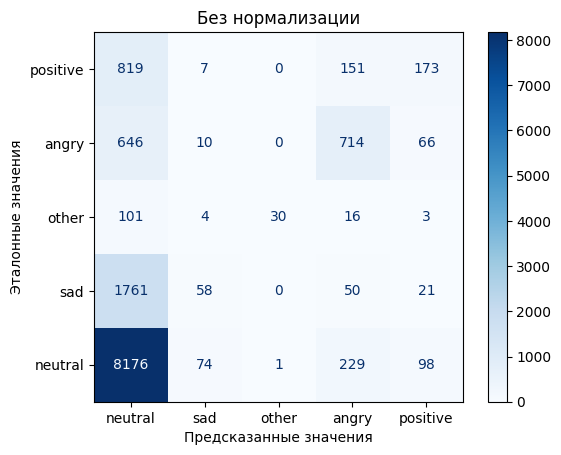

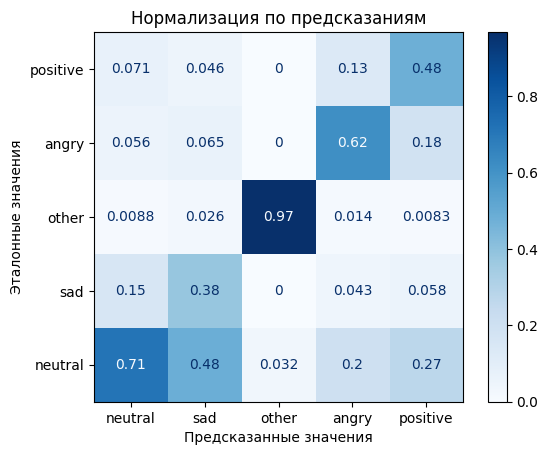

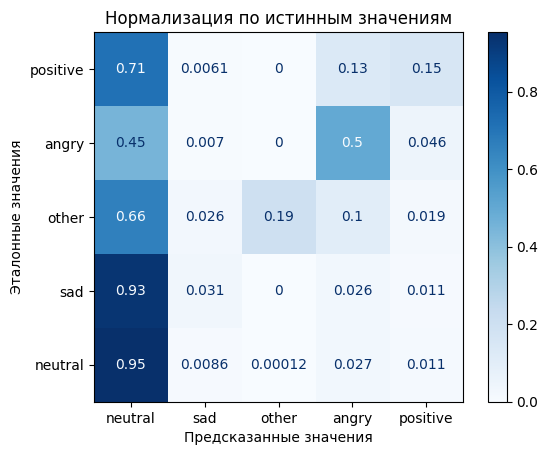

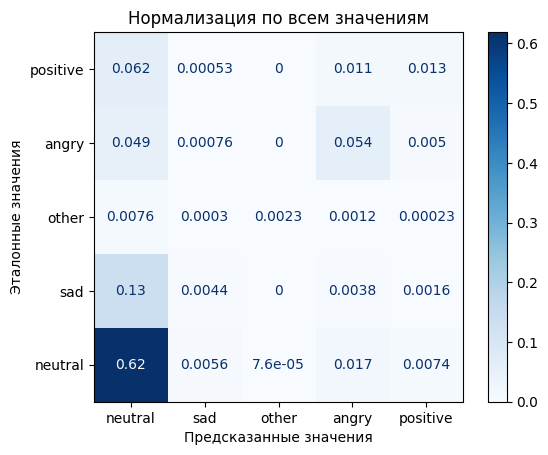

In [167]:
show_all_classification_metrics(y_true=y_test, y_pred=cb_y_pred)

In [79]:
n_estimators:int = cb.tree_count_

# Get the depth
depth = cb.get_param('depth')

# Get the number of parameters
n_params = cb.get_params()

print(f"Number of estimators: {n_estimators}")
print(f"Depth: {depth}")
print(f"Number of parameters: {len(n_params)}")


Number of estimators: 1000
Depth: None
Number of parameters: 1


In [80]:
classification_report_formatted(y_true=y_test, y_pred=cb_y_pred)

,angry,neutral,other,positive,sad,macro avg,weighted avg
precision,0.62,0.71,0.97,0.48,0.38,0.63,0.64
recall,0.50,0.95,0.19,0.15,0.03,0.37,0.69
f1-score,0.55,0.81,0.32,0.23,0.06,0.39,0.62
support,1436.00,8578.00,154.00,1150.00,1890.00,13208.00,13208.00


In [168]:
normed_feature_importance_cb:pd.Series = normalized_feature_importance(
    feature_names=X_train.columns,
    feature_weights=cb.feature_importances_, 
)
normed_feature_importance_cb.head()

loudness                                    0.218
transcription_features_meaning              0.101
HF_power_ratio                              0.100
transcription_features_mean_words_length    0.085
transcription_features_POS_ratio_NOUN       0.080
dtype: float64

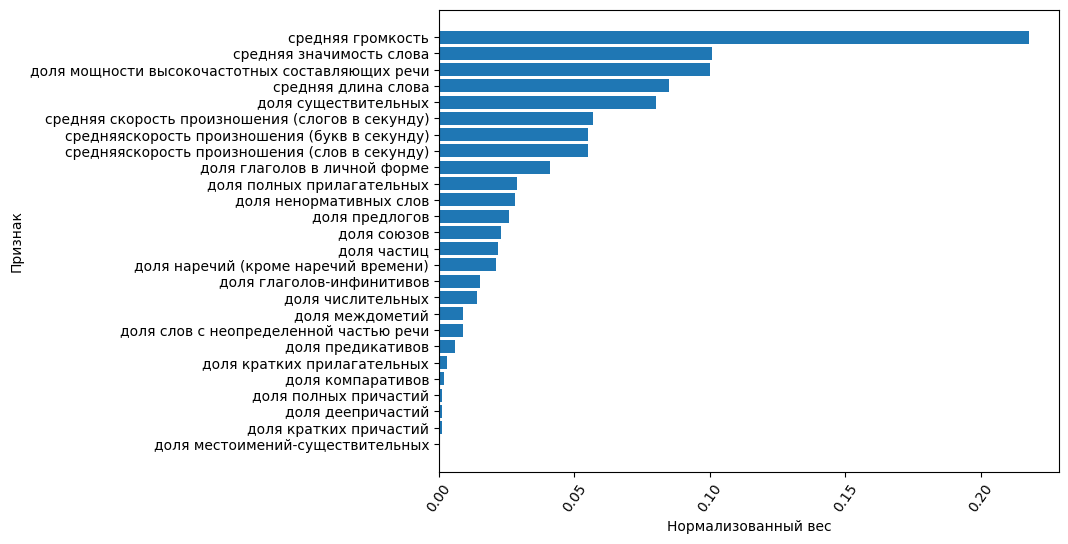

In [200]:
normalized_feature_importance_plot(
    feature_names=X_test_columns_ru,
    feature_weights=cb.feature_importances_, 
    xticks_rotation=55,
)

# Insights

## Permutation importance

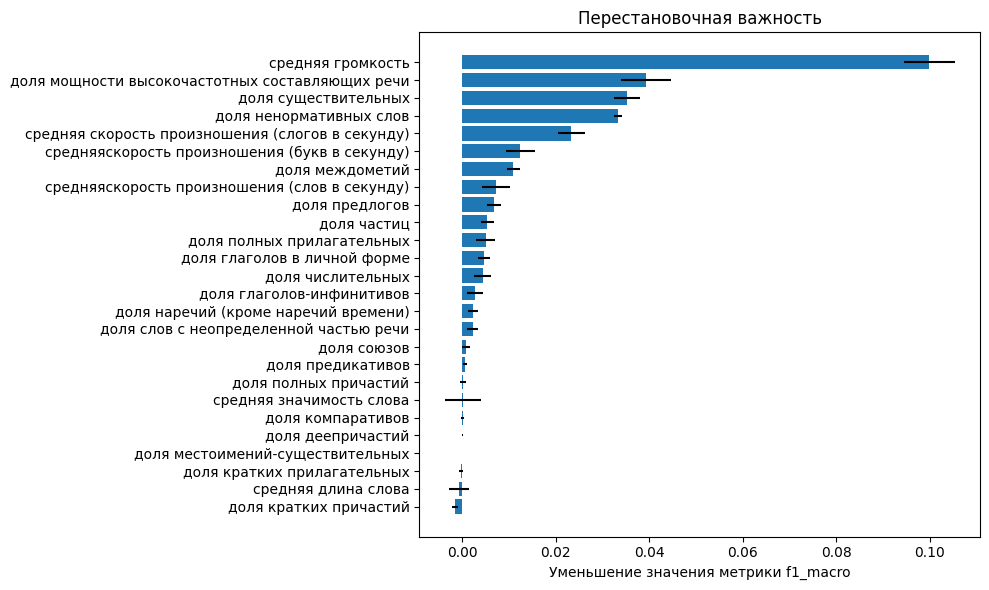

In [187]:
metric_name:str = 'f1_macro'  # accuracy, neg_log_loss
# Compute permutation importance
permutation_importance_result:Bunch = permutation_importance(
    estimator=cb, 
    X=X_test, 
    y=y_test,
    n_repeats=10,
    random_state=RANDOM_SEED,
    scoring=metric_name,
)

# Organize results
importance_df = pd.DataFrame({
    'features': X_test_columns_ru,
    'importance_mean': permutation_importance_result.importances_mean,
    'importance_std': permutation_importance_result.importances_std
}).sort_values('importance_mean', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(
    importance_df['features'],
    importance_df['importance_mean'], 
    xerr=importance_df['importance_std'],
    align=ALIGN_CENTER_KEYWORD,
)
plt.gca().invert_yaxis()  # Most important at top
plt.title('Перестановочная важность')
# plt.legend() # TODO: add xerr, and just bur explanation
plt.xlabel(f'Уменьшение значения метрики {metric_name}')
plt.tight_layout()
plt.show()

## Partial dependence

In [251]:
def cb_model_2_feature_importance_series(
    model:CatBoostClassifier,
    )->pd.Series:
    return pd.Series(index=model.feature_names_, data=model.feature_importances_)



['loudness', 'transcription_features_meaning', 'HF_power_ratio']

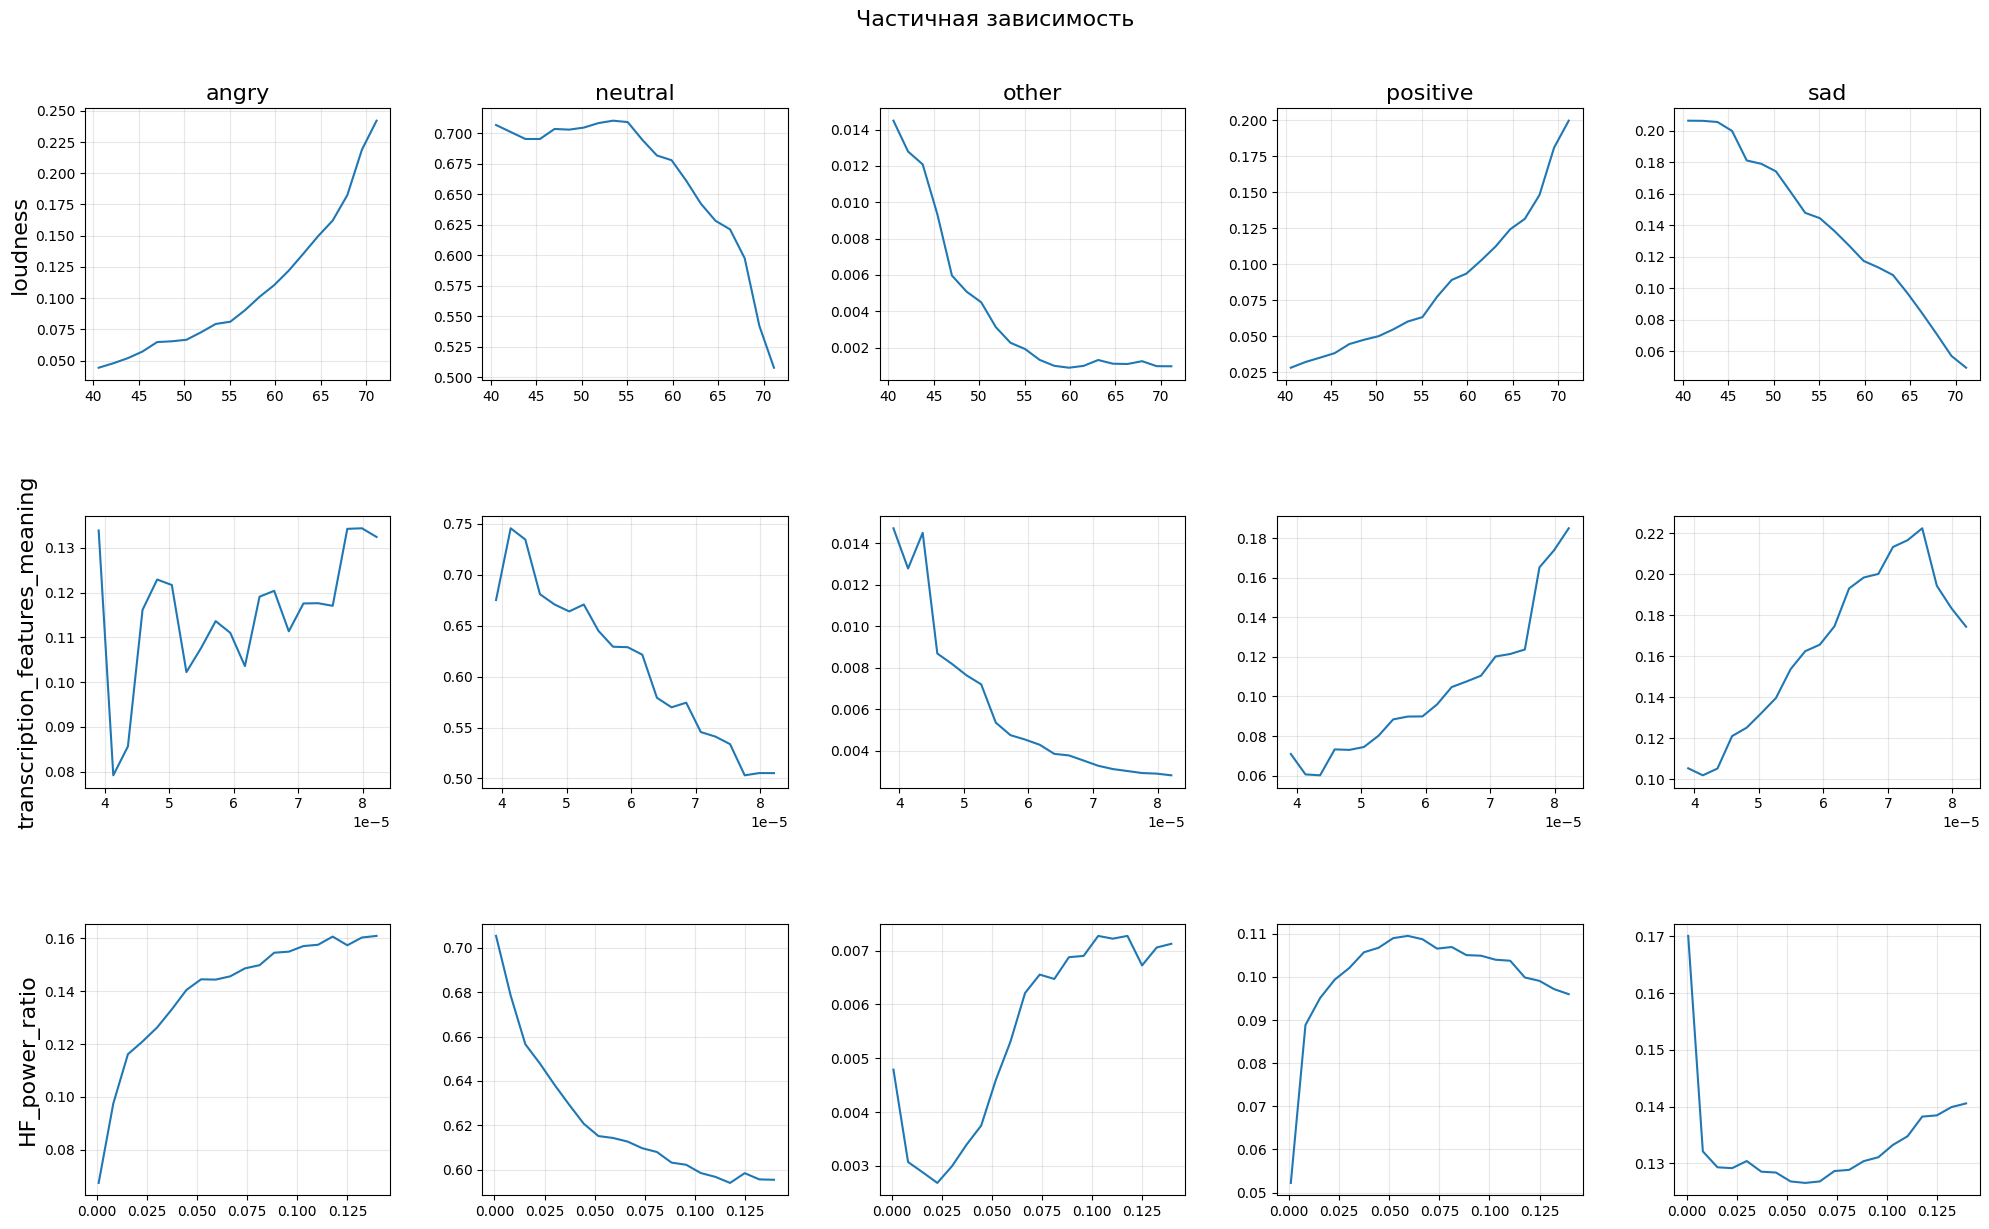

In [255]:
model_class_names:List[str] = cb.classes_
classes_quantity:int = len(model_class_names)
features:List[str] = cb_model_2_feature_importance_series(model=cb).sort_values(ascending=False).head(3).index.to_list()
features_quantity:int = len(features)

plt.figure(figsize=(20, 12))  
plt.suptitle('Частичная зависимость', fontsize=16, y=1.02)
for feature_idx, feature in enumerate(features):
    idx = X_test.columns.get_loc(feature)
    
    # Compute partial dependence for all classes
    pd_result = partial_dependence(
        cb,
        X_test,
        features=[idx],
        kind=PARTIAL_DEPENDENCE_KIND_AVERAGE,
        grid_resolution=20,
    )
    
    # Create subplots for each class
    for class_idx, class_name in enumerate(model_class_names):
        ax = plt.subplot(features_quantity, classes_quantity, feature_idx * classes_quantity + class_idx + 1)
        ax.plot(
            pd_result[PARTIAL_DEPENDENCE_GRID_VALUES][0],
            pd_result[PARTIAL_DEPENDENCE_KIND_AVERAGE][class_idx],
            color='tab:blue'
        )

        ax.grid(True, alpha=0.3)
        if feature_idx == 0:
            ax.set_title(f'{class_name}', fontsize=16)
        if class_idx == 0:
            ax.set_ylabel(f'{feature}', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()


## Decision tree

In [202]:
dtree:DecisionTreeClassifier = DecisionTreeClassifier(max_depth=10)
dtree.fit(X_train, y_train)
print(dtree.classes_)
dtree_y_pred:pd.Series = pd.Series(data= dtree.predict(X_test), index=y_test.index, name=PREDICTIONS_COL_NAME)

['angry' 'neutral' 'other' 'positive' 'sad']


              precision    recall  f1-score   support

       angry       0.58      0.46      0.51      1436
     neutral       0.70      0.96      0.81      8578
       other       0.95      0.13      0.23       154
    positive       0.40      0.04      0.07      1150
         sad       0.26      0.01      0.02      1890

    accuracy                           0.68     13208
   macro avg       0.58      0.32      0.33     13208
weighted avg       0.60      0.68      0.59     13208



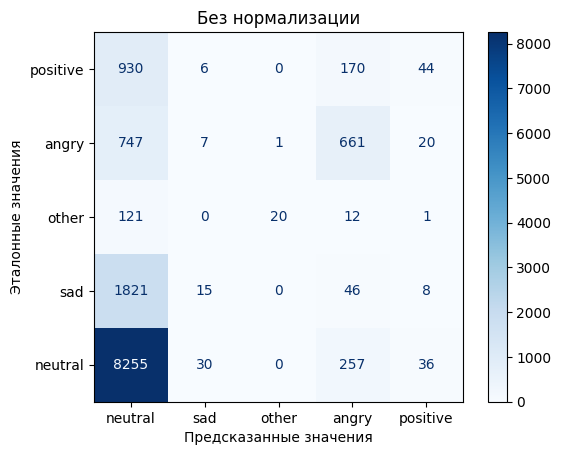

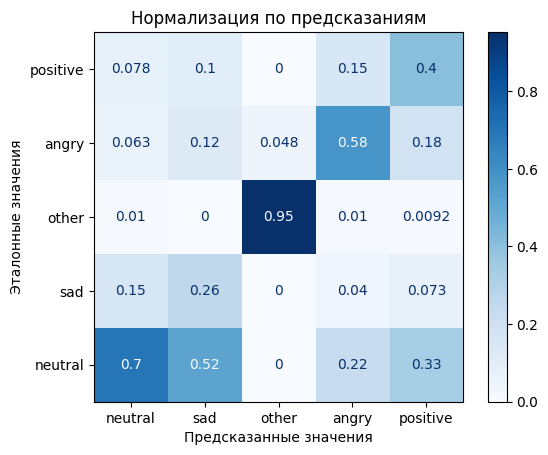

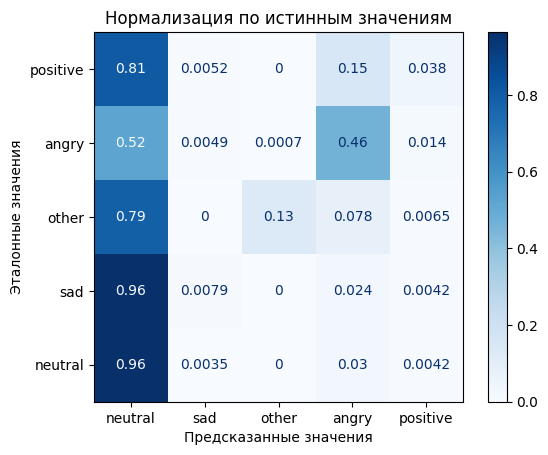

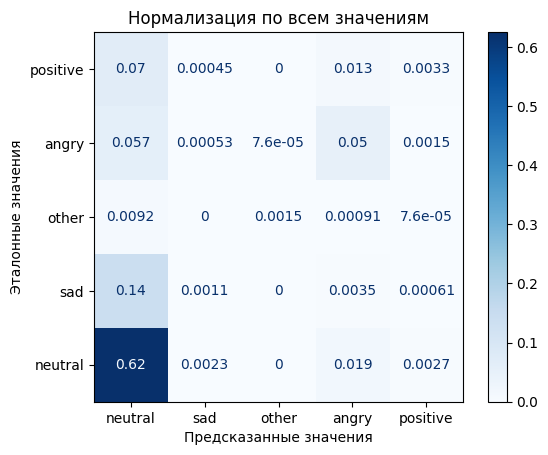

In [203]:
show_all_classification_metrics(y_true=y_test, y_pred=dtree_y_pred)

In [204]:
classification_report_formatted(y_true=y_test, y_pred=dtree_y_pred)

,angry,neutral,other,positive,sad,macro avg,weighted avg
precision,0.58,0.70,0.95,0.40,0.26,0.58,0.60
recall,0.46,0.96,0.13,0.04,0.01,0.32,0.68
f1-score,0.51,0.81,0.23,0.07,0.02,0.33,0.59
support,1436.00,8578.00,154.00,1150.00,1890.00,13208.00,13208.00


## Linear

In [128]:
scaler = StandardScaler()
X_train_normed = pd.DataFrame(data=scaler.fit_transform(X_train),columns=X_train.columns)
X_test_normed = pd.DataFrame(data=scaler.transform(X_test),columns=X_test.columns)

label_encoder:LabelEncoder = LabelEncoder()
y_encoded:pd.Series = pd.Series(
    label_encoder.fit_transform(y_train), 
    index=y_train.index,
)

In [132]:
linear_none = LogisticRegression(
    penalty=None, 
    multi_class=SKLEARN_MULTINOMIAL_KEYWORD,
    max_iter=1000,
)
linear_none.fit(X_train_normed, y_encoded)
linear_none_y_pred:pd.Series = pd.Series(data=label_encoder.inverse_transform(linear_none.predict(X_test)), index=X_test.index, name=PREDICTIONS_COL_NAME)
show_all_classification_metrics(y_true=y_test, y_pred=linear_none_y_pred, plot_cm=False)

/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

       angry       0.11      1.00      0.20      1436
     neutral       0.00      0.00      0.00      8578
       other       0.00      0.00      0.00       154
    positive       0.00      0.00      0.00      1150
         sad       0.00      0.00      0.00      1890

    accuracy                           0.11     13208
   macro avg       0.02      0.20      0.04     13208
weighted avg       0.01      0.11      0.02     13208



/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [134]:
# 2. L1 regularization (Lasso)
linear_l1 = LogisticRegression(
    penalty='l1', 
    solver='saga', 
    multi_class=SKLEARN_MULTINOMIAL_KEYWORD,
    max_iter=1000,
)
linear_l1.fit(X_train_normed, y_encoded)
linear_l1_pred:pd.Series = pd.Series(linear_l1.predict(X_test_normed), name=PREDICTIONS_COL_NAME)
linear_l1_pred:pd.Series = pd.Series(data=label_encoder.inverse_transform(linear_l1.predict(X_test)), index=X_test.index, name=PREDICTIONS_COL_NAME)
show_all_classification_metrics(y_true=y_test, y_pred=linear_l1_pred, plot_cm=False)

/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

       angry       0.11      1.00      0.20      1436
     neutral       0.00      0.00      0.00      8578
       other       0.00      0.00      0.00       154
    positive       0.00      0.00      0.00      1150
         sad       0.00      0.00      0.00      1890

    accuracy                           0.11     13208
   macro avg       0.02      0.20      0.04     13208
weighted avg       0.01      0.11      0.02     13208



/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [133]:
# 3. L2 regularization (Ridge)
linear_l2 = LogisticRegression(
    penalty='l2', 
    multi_class=SKLEARN_MULTINOMIAL_KEYWORD,
    max_iter=1000,
)
linear_l2.fit(X_train_normed, y_encoded)
linear_l2_pred:pd.Series = pd.Series(linear_l2.predict(X_test_normed), name=PREDICTIONS_COL_NAME)
linear_l2_pred:pd.Series = pd.Series(data=label_encoder.inverse_transform(linear_l2.predict(X_test)), index=X_test.index, name=PREDICTIONS_COL_NAME)
show_all_classification_metrics(y_true=y_test, y_pred=linear_l2_pred, plot_cm=False)

/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

       angry       0.11      1.00      0.20      1436
     neutral       0.00      0.00      0.00      8578
       other       0.00      0.00      0.00       154
    positive       0.00      0.00      0.00      1150
         sad       0.00      0.00      0.00      1890

    accuracy                           0.11     13208
   macro avg       0.02      0.20      0.04     13208
weighted avg       0.01      0.11      0.02     13208



/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vvkiselev/projects/dpl/venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

## Text embeddings

In [ ]:
# from transformers import AutoTokenizer, AutoModel
# import torch

# # Initialize model and tokenizer
# ROSBERTA_EMBEDDER_MODEL_NAME:str = 'ai-forever/ru-en-RoSBERTa'
# tokenizer = AutoTokenizer.from_pretrained(ROSBERTA_EMBEDDER_MODEL_NAME)
# model = AutoModel.from_pretrained(ROSBERTA_EMBEDDER_MODEL_NAME)

# def mean_pooling(model_output, attention_mask):
#     token_embeddings = model_output.last_hidden_state
#     input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
#     return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# # Russian text processing
# texts = ["Ваш текст на русском языке здесь"]
# encoded_input = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')

# with torch.no_grad():
#     model_output = model(**encoded_input)

# # Choose pooling method
# embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
# # embeddings = model_output.last_hidden_state[:,0]  # CLS pooling alternative


In [ ]:
def mean_pooling(
    model_output:transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions, 
    attention_mask:torch.Tensor,
    )->torch.Tensor:
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=CLAMP_MIN)


In [242]:
model_path:Path = Path('/data01/vvkiselev/data/other/dpl/models/ru-en-RoSBERTa')
tokenizer:transformers.models.roberta.tokenization_roberta_fast.RobertaTokenizerFast = AutoTokenizer.from_pretrained(model_path)
model:transformers.models.roberta.modeling_roberta.RobertaModel = AutoModel.from_pretrained(model_path).to(ROSBERTA_DEVICE)

Some weights of RobertaModel were not initialized from the model checkpoint at /data01/vvkiselev/data/other/dpl/models/ru-en-RoSBERTa and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [244]:
def texts_2_embeddings(
    texts:List[str],
    tokenizer:transformers.models.roberta.tokenization_roberta_fast.RobertaTokenizerFast,
    model:transformers.models.roberta.modeling_roberta.RobertaModel,
    padding:bool=True,
    truncation:bool=False,
    return_tensors=TORCH_TENSORS_KEYWOED,
    device=ROSBERTA_DEVICE,
    attention_mask_keyword:str=ATTENTION_MASK_KEYWORD,
    normalize_p:int = ROSBERTA_NORMALIZE_P,
    normalize_dim:int = ROSBERTA_NORMALIZE_DIM,
    )->torch.Tensor:
    inputs:transformers.tokenization_utils_base.BatchEncoding = tokenizer(
        texts,
        padding=padding,
        truncation=truncation,
        return_tensors=return_tensors,
    ).to(device)  # Move inputs to GPU

    # Generate embeddings
    with torch.no_grad():
        outputs:transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions = model(**inputs)

    # Apply manual pooling
    sentence_embeddings:torch.Tensor = mean_pooling(
        model_output=outputs, 
        attention_mask=inputs[attention_mask_keyword],
    )
    embeddings:torch.Tensor = torch.nn.functional.normalize(
        sentence_embeddings, 
        p=normalize_p, 
        dim=normalize_dim,
    )

    # print(f"Embedding shape: {embeddings.shape}")  # Output: torch.Size([1, 1024])
    return embeddings



In [269]:
embs:torch.Tensor = texts_2_embeddings(
    # texts=['Пример русского текста для анализа','я пошел гулять'],
    texts=list(filter(lambda x: isinstance(x, str), list(raw_crowd_train[SPEAKER_TEXT_FIELD_NAME].head(5000).unique()))),
    tokenizer=tokenizer,
    model=model,
)
embs.shape

torch.Size([2112, 1024])

In [256]:
raw_crowd_train.head()[SPEAKER_TEXT_FIELD_NAME].to_list()

['не надо не надо не надо не надо',
 'фозил кори mp три',
 nan,
 'сколько стоит на керамбит',
 'афина когда закончится эта телепередача']

In [296]:
def transcriptions_series_to_text_2_emb(
    transcriptions_series:pd.Series,
    tokenizer:transformers.models.roberta.tokenization_roberta_fast.RobertaTokenizerFast,
    model:transformers.models.roberta.modeling_roberta.RobertaModel,
    num_chunks:int,
    padding:bool=True,
    truncation:bool=False,
    return_tensors=TORCH_TENSORS_KEYWOED,
    device=ROSBERTA_DEVICE,
    attention_mask_keyword:str=ATTENTION_MASK_KEYWORD,
    normalize_p:int = ROSBERTA_NORMALIZE_P,
    normalize_dim:int = ROSBERTA_NORMALIZE_DIM,
    )->Dict[str, torch.Tensor]:
    unique_texts:List[str] = list(
        filter(
            lambda x: isinstance(x, str), 
            list(transcriptions_series.unique())
        )
    )
    print(f'len(unique_texts) = {len(unique_texts)}')

    chunks:List[List[str]] = divide_into_chunks(unique_texts, num_chunks)
    unique_text_2_embedding:Dict[str, torch.Tensor] = {}
    for chunk in tqdm(chunks):
        chunk_embeddings:torch.Tensor = texts_2_embeddings(
            texts=chunk,
            tokenizer=tokenizer,
            model=model,
            padding=padding,
            truncation=truncation,
            return_tensors=return_tensors,
            device=device,
            attention_mask_keyword=attention_mask_keyword,
            normalize_p=normalize_p,
            normalize_dim=normalize_dim,
        ).cpu()
        # print(f'chunk_embeddings.shape = {chunk_embeddings.shape}')
        for chunk_i in range(len(chunk)):
            unique_text_2_embedding[chunk[chunk_i]] = chunk_embeddings[chunk_i]

    return unique_text_2_embedding
        

In [304]:
text_2_emb_train:Dict[str, torch.Tensor] = transcriptions_series_to_text_2_emb(
    transcriptions_series=raw_crowd_train[SPEAKER_TEXT_FIELD_NAME],
    tokenizer=tokenizer,
    model=model,
    num_chunks=100,
)

len(unique_texts) = 124568


100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


In [310]:
text_2_emb_series_train:pd.Series = pd.Series(index=text_2_emb_train.keys(), data=map(repr, text_2_emb_train.values()))
text_2_emb_series_train.head()

не надо не надо не надо не надо                   tensor([ 0.0409,  0.0645, -0.0062,  ...,  0.01...
фозил кори mp три                                 tensor([-0.0066,  0.0331,  0.0023,  ...,  0.01...
сколько стоит на керамбит                         tensor([ 0.0246,  0.0035,  0.0029,  ..., -0.02...
афина когда закончится эта телепередача           tensor([ 0.0242,  0.0469,  0.0188,  ...,  0.01...
где проживают дети путина тихонова и воронцова    tensor([-0.0016, -0.0451, -0.0002,  ...,  0.05...
dtype: object

In [333]:
torch.save(text_2_emb_train, PROCESSED_DUSHA_CROWD_TRAIN_TEXT_EMBEDDINGS_LAST_VERSION_FILE_PATH)

In [332]:
# Load the dictionary from the file
# loaded_dict = torch.load(PROCESSED_DUSHA_CROWD_TRAIN_TEXT_EMBEDDINGS_LAST_VERSION_FILE_PATH, weights_only=False)
# list(loaded_dict.items())[0][1].shape

FileNotFoundError: [Errno 2] No such file or directory: '/data01/vvkiselev/data/other/dpl/processed/dusha/crowd/train/text_embeddings/v1.pt'

In [297]:
text_2_emb_test:Dict[str, torch.Tensor] = transcriptions_series_to_text_2_emb(
    transcriptions_series=raw_crowd_test[SPEAKER_TEXT_FIELD_NAME],
    tokenizer=tokenizer,
    model=model,
    num_chunks=100,
)

len(unique_texts) = 16628


100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


In [334]:
torch.save(text_2_emb_test, PROCESSED_DUSHA_CROWD_TEST_TEXT_EMBEDDINGS_LAST_VERSION_FILE_PATH)

In [335]:
loaded_dict = torch.load(PROCESSED_DUSHA_CROWD_TEST_TEXT_EMBEDDINGS_LAST_VERSION_FILE_PATH, weights_only=False)
list(loaded_dict.items())[0][1].shape

torch.Size([1024])

In [ ]:
# import spacy

# # Load the Russian language model
# nlp = spacy.load("ru_core_news_sm")

# # Sample Russian text
# text = "Я люблю программировать на Python."

# # Process the text
# doc = nlp(text)

# # Iterate through tokens and print their text and POS
# for token in doc:
#     print(f"Word: {token.text}, POS: {token.pos_}")


# Analyse